In [21]:
import sys
sys.path.append('/home2/jupyter-s.kim/.local/lib/python3.7/site-packages/') # jupyter와 같은 package를 사용하기 위한 경로

import library

In [22]:
### default
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import random
import time
import copy
from datetime import datetime

### modeling
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

### visualization
import seaborn as sns
from matplotlib import pyplot as plt

In [23]:
# 센서 종류
sensors = ['C7H8', 'TMA', 'VOC', 'CO2', 'HCHO', 'H2S', 'NH3', 'CH3SH', 'SO2', 'NO2', 'CO']
cols = ['C7H8', 'TMA', 'VOC', 'CO2', 'HCHO', 'H2S', 'NH3', 'CH3SH', 'SO2', 'NO2', 'CO', 'reg_date', 'label_type']

In [24]:
# df = pd.read_csv('df_type_total_230403.csv') # 3~7차 데이터셋
df = pd.read_csv('df_type_total_230407.csv') # 3~9차 데이터셋

In [25]:
df = df[cols]

In [28]:
df_train = df[pd.to_datetime(df['reg_date']) <= datetime(2023,4,1)]
df_test = df[pd.to_datetime(df['reg_date']) > datetime(2023,4,1)]

In [30]:
df_test['label_type'].value_counts()

B     2640
ME    2456
Name: label_type, dtype: int64

파라미터 세팅

In [43]:
NUM_CLASSES = len(df_train['label_type'].unique())

함수정의

In [71]:
# 데이터셋을 만들기 위한 실험 구분
def create_experiment_number(data):
    data['lagged'] = data['reg_date'].shift(-1)
    data['reg_date'] = pd.to_datetime(data['reg_date'])
    data['lagged'] = pd.to_datetime(data['lagged'])
    data['diff'] = data['lagged'] - data['reg_date']
    data['diff'] = data['diff'] /  pd.Timedelta('1s')
    data['diff'].fillna(1,inplace=True) #마지막줄 채워주기 위함
    data.reset_index(drop=True, inplace=True)

    num = 0
    for i in range(len(data)):
        if data.loc[i,'diff'] in [1,2]:
            data.loc[i,'exp_num'] = num
        else:
            data.loc[i,'exp_num'] = num
            num+=1
    return data

# 실험 별로 시계열 데이터셋을 만들기 위한 함수
def create_windows(data, window_size=5):
    X = []
    y = []
    for num, group_df in data.groupby('exp_num'):
        data = group_df.iloc[:, 0:11].values
        labels = group_df['label_type'].values
        for i in range(len(data) - window_size + 1):
            X.append(data[i:i+window_size])
            y.append(labels[window_size-1])

    return np.array(X), np.array(y)

# 데이터셋을 train/valid/test로 나누는 함수
def split_data(X, y, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    assert train_ratio + val_ratio + test_ratio == 1, "The sum of the ratios must be equal to 1."
    assert len(X) == len(y), "The length of X and y must be the same."
    
    # numpy 배열을 torch 텐서로 변환합니다.
    X = torch.from_numpy(X)
    y = torch.from_numpy(y)

    # 데이터를 무작위로 섞기 위한 인덱스를 생성합니다.
    shuffled_indices = torch.randperm(len(X))

    # 비율에 따라 인덱스를 설정합니다.
    train_cnt = int(len(X) * train_ratio)
    val_cnt = int(len(X) * val_ratio)
    test_cnt = len(X) - (train_cnt + val_cnt)

    # 데이터를 train, validation, test 셋으로 나눕니다 (torch.index_select 사용).
    X_train, X_val, X_test = torch.index_select(X, dim=0, index=shuffled_indices).split([train_cnt, val_cnt, test_cnt], dim=0)
    y_train, y_val, y_test = torch.index_select(y, dim=0, index=shuffled_indices).split([train_cnt, val_cnt, test_cnt], dim=0)
    
    print('---'*30)
    print('Splitting Complete')
    print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)
    return X_train, y_train, X_val, y_val, X_test, y_test

# torch dataloader를 만들기 위한 함수
def create_classification_dataset(data, window_size, batch_size):
    X, y = create_windows(data, window_size)
        
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

    encoder = LabelEncoder()
    y = encoder.fit_transform(y)
    y = to_categorical(y, num_classes=NUM_CLASSES)

    X = X.transpose(0,2,1)
    X = X.astype(np.float32)
    y = y.astype(np.float32)
       
    X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y)

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)

    # DataLoader 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, encoder, scaler

# torch dataloader를 만들기 위한 함수
def create_test_dataset(data, window_size, batch_size, scaler, encoder):
    X, y = create_windows(data, window_size)

    X = scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
    y = encoder.transform(y)
    y = to_categorical(y, num_classes=NUM_CLASSES)

    X = X.transpose(0,2,1)
    X = X.astype(np.float32)
    y = y.astype(np.float32)

    # numpy 배열을 torch 텐서로 변환합니다.
    X = torch.from_numpy(X)
    y = torch.from_numpy(y)

    real_test_dataset = TensorDataset(X, y)

    # DataLoader 생성
    real_test_loader = DataLoader(real_test_dataset, batch_size=batch_size, shuffle=False)

    return real_test_loader

def plot_metrics(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    acc_list = [t.item() for t in history['train_acc']]
    val_acc_list = [t.item() for t in history['val_acc']]
    plt.plot(acc_list)
    plt.plot(val_acc_list)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')

    plt.show()

데이터 전처리

In [45]:
df_train = create_experiment_number(df_train)
df_train.head()

,C7H8,TMA,VOC,CO2,HCHO,H2S,NH3,CH3SH,SO2,NO2,CO,reg_date,label_type,lagged,diff,exp_num
0,0.000000,0.000026,0.192282,435.1554,0.00000,0.303789,0.809661,0.0,0.050841,0.012979,0.323783,2023-03-13 12:52:05,B,2023-03-13 12:52:06,1.0,0.0
1,0.000000,0.000034,0.357748,431.6093,0.00000,0.528598,3.488177,0.0,0.190711,0.000000,0.291240,2023-03-13 12:52:06,B,2023-03-13 12:52:08,2.0,0.0
2,0.000000,0.000045,0.498292,326.9812,0.00000,0.688187,9.506214,0.0,0.233748,0.000000,0.230189,2023-03-13 12:52:08,B,2023-03-13 12:52:09,1.0,0.0
3,0.000944,0.000057,0.728273,295.0207,0.00000,0.815260,9.946881,0.0,0.176365,0.000000,0.205769,2023-03-13 12:52:09,B,2023-03-13 12:52:10,1.0,0.0
4,0.002350,0.000073,1.036101,324.5227,0.79195,0.911156,9.946881,0.0,0.130409,0.000000,0.150823,2023-03-13 12:52:10,B,2023-03-13 12:52:12,2.0,0.0


pytorch를 사용한 1D-CNN 구현

In [46]:
# Hyperparameter setting
batch_size = 32
num_classes = NUM_CLASSES
num_epochs = 50
window_size = 5
feature_len = 11

random_seed = 42
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Detect if we have a GPU available

In [47]:
# seed 고정
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [50]:
# Dataloader 구축
# data shape: (batch_size x input_size x seq_len) => (32, 11, 5)
train_loader, valid_loader, test_loader, encoder, scaler = create_classification_dataset(df_train, window_size, batch_size)

------------------------------------------------------------------------------------------
Splitting Complete
torch.Size([4840, 11, 5]) torch.Size([4840, 6]) torch.Size([605, 11, 5]) torch.Size([605, 6]) torch.Size([606, 11, 5]) torch.Size([606, 6])


In [51]:
# DataLoader에서 데이터 형태 확인
for batch_idx, (inputs, targets) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1} - Inputs shape: {inputs.shape}, Targets shape: {targets.shape}")
    break

Batch 1 - Inputs shape: torch.Size([32, 11, 5]), Targets shape: torch.Size([32, 6])


In [52]:
# DataLoader에서 데이터 형태 확인
for batch_idx, (inputs, targets) in enumerate(test_loader):
    print(f"Batch {batch_idx + 1} - Inputs shape: {inputs.shape}, Targets shape: {targets.shape}")
    break

Batch 1 - Inputs shape: torch.Size([32, 11, 5]), Targets shape: torch.Size([32, 6])


In [53]:
# 1-dimensional convolution layer로 구성된 CNN 모델
# 2개의 1-dimensional convolution layer와 1개의 fully-connected layer로 구성되어 있음
class CNN_1D(nn.Module):
    def __init__(self, in_channel, out_channel, num_classes):

        self.in_channel = in_channel
        self.out_channel = out_channel
        self.num_classes = num_classes

        super(CNN_1D, self).__init__()
        # 첫 번째 1-dimensional convolution layer 구축
        self.layer1 = nn.Sequential(
            nn.Conv1d(in_channel, out_channel, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size=2, stride=2)
            # nn.MaxPool1d(kernel_size=2, stride=2)
        )
        # 두 번째 1-dimensional convolution layer 구축
        self.layer2 = nn.Sequential(
            nn.Conv1d(out_channel, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size=2, stride=2)
            # nn.MaxPool1d(kernel_size=2, stride=2)
        )
        # fully-connected layer 구축
        self.fc = nn.Linear(32*1, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [54]:
# 1D CNN 구축
model = CNN_1D(in_channel=feature_len, out_channel=16, num_classes=NUM_CLASSES) # in_channel은 feature의 갯수
model = model.to(device)
print(model)

CNN_1D(
  (layer1): Sequential(
    (0): Conv1d(11, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  )
  (layer2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  )
  (fc): Linear(in_features=32, out_features=6, bias=True)
)


In [55]:
from torchsummary import summary

In [56]:
summary(model, input_size = (11,5))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                [-1, 16, 5]             544
              ReLU-2                [-1, 16, 5]               0
         AvgPool1d-3                [-1, 16, 2]               0
            Conv1d-4                [-1, 32, 2]           1,568
              ReLU-5                [-1, 32, 2]               0
         AvgPool1d-6                [-1, 32, 1]               0
            Linear-7                    [-1, 6]             198
Total params: 2,310
Trainable params: 2,310
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [57]:
# Adam optimizer 구축하기
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [58]:
def train_model(model, dataloaders, criterion, num_epochs, optimizer):
    since = time.time()

    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        train_loss = 0
        val_loss = 0
        train_corrects = 0
        val_corrects = 0
        train_total = 0
        val_total = 0

        # 각 epoch마다 순서대로 training과 validation을 진행
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 training mode로 설정
            else:
                model.eval()   # 모델을 validation mode로 설정            

            # training과 validation 단계에 맞는 dataloader에 대하여 학습/검증 진행
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # parameter gradients를 0으로 설정
                optimizer.zero_grad()

                # forward
                # training 단계에서만 gradient 업데이트 수행
                with torch.set_grad_enabled(phase == 'train'):
                    # input을 model에 넣어 output을 도출한 후, loss를 계산함
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # output 중 최댓값의 위치에 해당하는 class로 예측을 수행
                    _, preds = torch.max(outputs, 1)

                    # backward (optimize): training 단계에서만 수행
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # batch별 loss를 축적함
                if phase == 'train':
                    # running_loss += loss.item() * inputs.size(0)
                    # running_corrects += torch.sum(preds == torch.argmax(labels, dim=-1))
                    # running_total += labels.size(0)

                    train_loss += loss.item() * inputs.size(0)
                    # train_loss += loss.item() 
                    train_corrects += torch.sum(preds == torch.argmax(labels, dim=-1))
                    train_total += labels.size(0)

                else:
                    val_loss += loss.item() * inputs.size(0)
                    # val_loss += loss.item()
                    val_corrects += torch.sum(preds == torch.argmax(labels, dim=-1))
                    val_total += labels.size(0)
            
        train_loss_epoch = train_loss/train_total
        val_loss_epoch = val_loss/val_total
        train_acc_epoch = train_corrects.double() /train_total
        val_acc_epoch = val_corrects.double() /val_total

        # epoch의 loss 및 accuracy 도출
        # epoch_loss = running_loss / running_total
        # epoch_acc = running_corrects.double() / running_total

        # validation 단계에서 validation loss가 감소할 때마다 best model 가중치를 업데이트함
        if phase == 'val' and val_acc_epoch > best_acc:
            best_acc = val_acc_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            print('update model parameter')

        train_acc_history.append(train_acc_epoch)
        val_acc_history.append(val_acc_epoch)
        train_loss_history.append(train_loss_epoch)
        val_loss_history.append(val_loss_epoch)
            
            # if phase == 'val':
            #     val_acc_history.append(val_acc_epoch)
            
        print(f'{epoch+1} epoch | Train loss: {train_loss_epoch:.3f}, Valid loss: {val_loss_epoch:.3f}')
        print(f'{epoch+1} epoch | Train acc: {train_acc_epoch:.3f}, Valid acc: {val_acc_epoch:.3f}')
        print()

    # 전체 학습 시간 계산
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # validation loss가 가장 낮았을 때의 best model 가중치를 불러와 best model을 구축함
    model.load_state_dict(best_model_wts)
    history = {'train_acc':train_acc_history, 'val_acc':val_acc_history, 'train_loss':train_loss_history, 'val_loss':val_loss_history}
    
    # best model 가중치 저장
    # torch.save(best_model_wts, '../output/best_model.pt')
    return model, history

In [59]:
# trining 단계에서 사용할 Dataloader dictionary 생성
dataloaders_dict = {
    'train': train_loader,
    'val': valid_loader
}
# loss function 설정
criterion = nn.CrossEntropyLoss()

In [60]:
# 모델 학습
model, history = train_model(model, dataloaders_dict, criterion, num_epochs, optimizer)

Epoch 1/50
----------
update model parameter
1 epoch | Train loss: 1.440, Valid loss: 1.045
1 epoch | Train acc: 0.430, Valid acc: 0.593

Epoch 2/50
----------
update model parameter
2 epoch | Train loss: 0.871, Valid loss: 0.776
2 epoch | Train acc: 0.644, Valid acc: 0.701

Epoch 3/50
----------
update model parameter
3 epoch | Train loss: 0.705, Valid loss: 0.665
3 epoch | Train acc: 0.707, Valid acc: 0.719

Epoch 4/50
----------
update model parameter
4 epoch | Train loss: 0.629, Valid loss: 0.608
4 epoch | Train acc: 0.736, Valid acc: 0.745

Epoch 5/50
----------
update model parameter
5 epoch | Train loss: 0.582, Valid loss: 0.571
5 epoch | Train acc: 0.751, Valid acc: 0.790

Epoch 6/50
----------
update model parameter
6 epoch | Train loss: 0.548, Valid loss: 0.533
6 epoch | Train acc: 0.773, Valid acc: 0.812

Epoch 7/50
----------
update model parameter
7 epoch | Train loss: 0.511, Valid loss: 0.501
7 epoch | Train acc: 0.805, Valid acc: 0.835

Epoch 8/50
----------
8 epoch | Tr

In [63]:
def test_model(model, test_loader):
    model.eval()   # 모델을 validation mode로 설정

    pred_list = []
    true_list = []

    # test_loader에 대하여 검증 진행 (gradient update 방지)
    with torch.no_grad():
        corrects = 0
        total = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward
            # input을 model에 넣어 output을 도출
            outputs = model(inputs)

            # output 중 최댓값의 위치에 해당하는 class로 예측을 수행
            _, preds = torch.max(outputs, 1)

            # batch별 정답 개수를 축적함
            corrects += torch.sum(preds == torch.argmax(labels, dim=-1))
            total += labels.size(0)

            pred_list.extend(preds.detach().numpy())
            true_list.extend(torch.argmax(labels, dim=-1).detach().numpy())

    # accuracy를 도출함
    test_acc = corrects.double() / total
    print('Testing Acc: {:.4f}'.format(test_acc))

    return pred_list, true_list

In [64]:
# 모델 검증 
pred_list, true_list = test_model(model, test_loader)

Testing Acc: 0.9373


In [65]:
# 평가지표 계산
test_acc = accuracy_score(true_list, pred_list)
test_rec = recall_score(true_list, pred_list, average='macro')
test_prec = precision_score(true_list, pred_list, average='macro')
test_f1 = f1_score(true_list, pred_list, average='macro')

print('Test Accuracy   : {:.3f}'.format(test_acc))
print('Test Sensitivity: {:.3f}'.format(test_rec))
print('Test Precision  : {:.3f}'.format(test_prec))
print('Test F1 Score   : {:.3f}'.format(test_f1))

Test Accuracy   : 0.937
Test Sensitivity: 0.936
Test Precision  : 0.938
Test F1 Score   : 0.936


findfont: Font family ['NanumGothinc'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothinc'] not found. Falling back to DejaVu Sans.


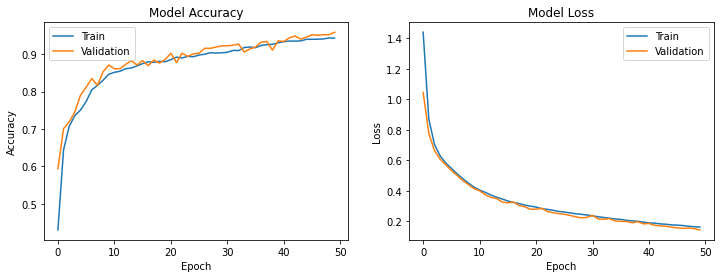

In [66]:
plot_metrics(history)

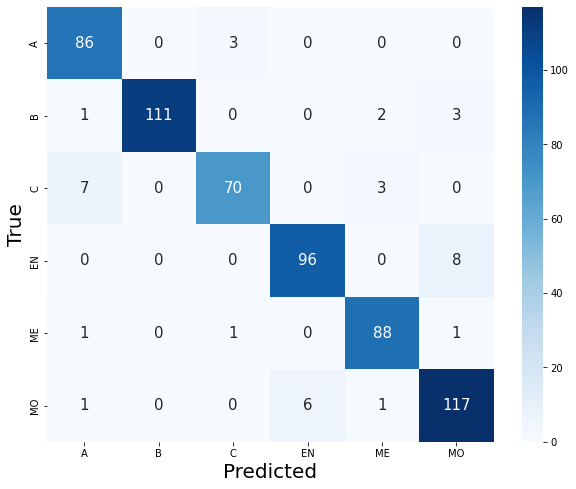

In [74]:
# confusion matrix 계산
cm = confusion_matrix(y_true=true_list, y_pred=pred_list)
cm_df = pd.DataFrame(cm)

cm_df.index = encoder.classes_
cm_df.columns = encoder.classes_

# confusion matrix 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(data=cm_df, annot=True, fmt='d', annot_kws={'size': 15}, cmap='Blues')
plt.xlabel('Predicted', size=20)
plt.ylabel('True', size=20)
plt.show()

In [68]:
df_test = create_experiment_number(df_test)
df_test.head()

,C7H8,TMA,VOC,CO2,HCHO,H2S,NH3,CH3SH,SO2,NO2,CO,reg_date,label_type,lagged,diff,exp_num
0,0.033189,0.000070,0.511069,100.79880,0.0,0.206896,0.618528,0.0,0.0,0.016224,1.322998,2023-04-03 13:20:34,ME,2023-04-03 13:20:36,2.0,0.0
1,0.045531,0.000076,0.550266,169.63690,0.0,0.319673,1.126904,0.0,0.0,0.008808,1.365734,2023-04-03 13:20:36,ME,2023-04-03 13:20:37,1.0,0.0
2,0.060589,0.000080,0.549399,99.92882,0.0,0.450816,1.672414,0.0,0.0,0.002323,1.347419,2023-04-03 13:20:37,ME,2023-04-03 13:20:39,2.0,0.0
3,0.076748,0.000082,0.550266,70.44612,0.0,0.579394,2.248468,0.0,0.0,0.000000,1.359628,2023-04-03 13:20:39,ME,2023-04-03 13:20:40,1.0,0.0
4,0.091999,0.000083,0.550266,60.61852,0.0,0.692952,2.811248,0.0,0.0,0.000000,1.310788,2023-04-03 13:20:40,ME,2023-04-03 13:20:41,1.0,0.0


In [84]:
len(r_true_list)

4856

In [72]:
# Test Dataloader 구축
# data shape: (batch_size x input_size x seq_len) => (32, 11, 5)
real_test_dataloader = create_test_dataset(df_test, window_size, batch_size, encoder=encoder, scaler=scaler)

In [73]:
r_pred_list, r_true_list = test_model(model, real_test_dataloader)

Testing Acc: 0.5931


In [ ]:
encoding_numbers = list(range(0,len(encoder.classes_)))
label_dict = dict(zip(encoding_numbers, encoder.inverse_transform(encoding_numbers)))
print(label_dict)

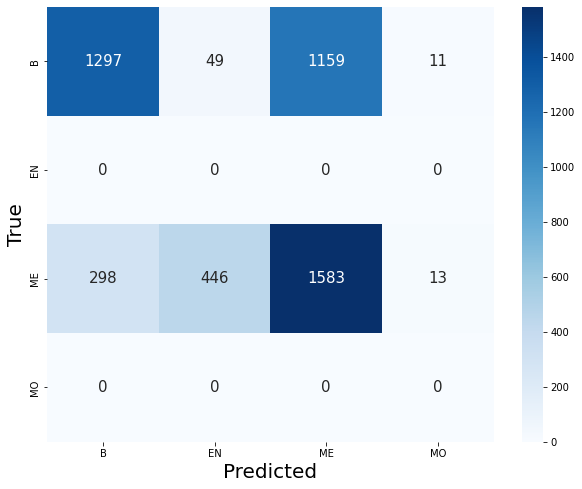

In [93]:
# confusion matrix 계산
cm = confusion_matrix(y_true=r_true_list, y_pred=r_pred_list)
cm_df = pd.DataFrame(cm, columns=np.unique(r_pred_list), index=np.unique(r_pred_list))

new_index = [label_dict[i] for i in cm_df.index]
new_columns = [label_dict[i] for i in cm_df.columns]

# 인덱스와 컬럼 이름 변경
cm_df = cm_df.rename(index=dict(zip(cm_df.index, new_index)), columns=dict(zip(cm_df.columns, new_columns)))

# confusion matrix 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(data=cm_df, annot=True, fmt='d', annot_kws={'size': 15}, cmap='Blues')
plt.xlabel('Predicted', size=20)
plt.ylabel('True', size=20)
plt.show()